In [1]:
import csv
import sys
import pandas as pd
import re
import pathlib

# Data Load

In [2]:
ls16raw = pd.read_csv("./libsort16b.csv", skiprows=[4], 
                 comment="=")

ls8raw = pd.read_csv("./libsort8b.csv", skiprows=[4], 
                 comment="=")

faasFirst16raw = pd.read_csv("./faasFirst16.csv")
faasFirst8raw = pd.read_csv("./faasFirst8.csv")

faasMid16raw = pd.read_csv("./faasMiddle16.csv")
faasMid8raw = pd.read_csv("./faasMiddle8.csv")

# Data Cleaning

In [61]:
renames = {
    "gpu_radix_sort_local(unsigned int*, unsigned int*, unsigned int*, unsigned int, unsigned int*, unsigned int, unsigned int)" : ("GpuSort", "core"),
    "[CUDA memcpy HtoD]" : ("Host->Device", "data"),
    "[CUDA memcpy DtoH]" : ("Device->Host", "data"),
    "gpu_glbl_shuffle(unsigned int*, unsigned int*, unsigned int*, unsigned int*, unsigned int, unsigned int, unsigned int)" : ("GpuShuffle", "core"),
    "gpu_prescan(unsigned int*, unsigned int const *, unsigned int*, unsigned int, unsigned int, unsigned int)" : ("GpuSortHelper0", "core"),
    'gpu_groups(unsigned int*, unsigned int*, int, int, unsigned int)' : ("GpuBoundaries", "distrib"),
    "gpu_add_block_sums(unsigned int*, unsigned int const *, unsigned int*, unsigned long)" : ("GpuSortHelper1", "core")
}

def cleanNvprof(orig):
    df = orig.copy()
    
    # subset for only significant api calls
    df = df[ df['Type'] == "GPU activities" ].drop(['Type'], axis=1)
    df = df[ df['Time(%)'] > 0.5 ]
    
    # Human readable names and categories
    for oldName, cleaned in renames.items():
        df.loc[ (df['Name'] == oldName), 'Category' ] = cleaned[1]
        df.loc[ (df['Name'] == oldName), 'Name' ] = cleaned[0]

    # summarize by category
    df = df.groupby(["Category"]).sum()[['Time(%)', 'Time']]

    return df

def cleanCprofile(orig):
    df = orig.copy()
    
    # Extract just the function name from the output
    reFname = re.compile(".*:.*\((.*)\)")
    def filterFName(x):
        m = reFname.match(x)
        if m is not None:
            return m.group(1)
        else:
            return x
        
    df.loc[:,['filename:lineno(function)']] = df.loc[:,['filename:lineno(function)']].applymap(filterFName)
    df.rename(columns={'filename:lineno(function)':"function"}, inplace=True)
    
    # Only want cumtime
    df = df.drop(['ncalls','tottime','percall', 'percall.1'], axis=1)
    
    # Convert to ms
    df['cumtime'] *= 1000
    
    df.rename(columns={'cumtime' : 'time'}, inplace=True)
    df.set_index('function', inplace=True)
    
    leaves = pd.Series(dtype=float)
    
    leaves['libsort'] = df.loc['sortPartial', 'time']
    leaves['writeMeta'] = df.loc['Close', 'time']
    leaves['writeData'] = df.loc['WriteAll', 'time']
    leaves['readData'] = df.loc['ReadPart', 'time']
    leaves['readMeta'] = (df.loc['readPartRefs', 'time'] + df.loc['getPartRefs', 'time']) - leaves['readData']
    # if 'other' isn't trivial, something has gone wrong in our accounting
    leaves['other'] = df.loc['f', 'time'].sum() - leaves.sum()
    
    return leaves

def combine(ls, py):
    faas = py.copy()
    faas['libsort-core'] = py['libsort'] - ls.loc['data', 'Time']
    faas['libsort-memcpy'] = py['libsort'] - ls.loc['core', 'Time']
    faas.drop('libsort', inplace=True)

    return faas

# Loads all repititions of the FaaS data and returns the cleaned means
def loadFaas(ls16, ls8):
    faasResDir = pathlib.Path("data")

    def loadOne(pattern, ls):
        raws = []
        for runPath in faasResDir.glob(pattern):
            raw = pd.read_csv(runPath)
            raws.append(combine(ls, cleanCprofile(raw)))
        rawsDF = pd.DataFrame(data=raws).T
        means = rawsDF.mean(axis=1)
        stds = rawsDF.std(axis=1)
        covs = stds / means
        return (means, stds, covs)
    
    res = {}
    f16 = loadOne("faasFirst_16b_*", ls16)
    m16 = loadOne("faasMiddle_16b_*", ls16)
    f8 = loadOne("faasFirst_8b_*", ls8)
    m8 = loadOne("faasMiddle_8b_*", ls8)
    
    means = {}
    covs = {}
    means['16b'] = pd.DataFrame(data=[f16[0], m16[0]], index=['First', 'Middle']).T
    means['8b'] = pd.DataFrame(data=[f8[0], m8[0]], index=['First', 'Middle']).T
    stds['16b'] = pd.DataFrame(data=[f16[1], m16[1]], index=['First', 'Middle']).T
    stds['8b'] = pd.DataFrame(data=[f8[1], m8[1]], index=['First', 'Middle']).T
    covs['16b'] = pd.DataFrame(data=[f16[2], m16[2]], index=['First', 'Middle']).T
    covs['8b'] = pd.DataFrame(data=[f8[2], m8[2]], index=['First', 'Middle']).T
    
    return means, stds, covs
    

ls16 = cleanNvprof(ls16raw)
ls8 = cleanNvprof(ls8raw)

prof = loadFaas(ls16, ls8)
means = prof[0]
stds = prof[1]
covs = prof[2]

# Plot Time Breakdowns

## LibSort

Text(0, 0.5, 'Time (ms)')

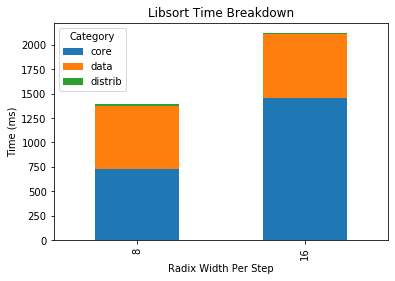

In [33]:
t8 = ls8.T.loc['Time'].rename("8")
t16 = ls16.T.loc['Time'].rename("16")
pltDf = pd.DataFrame([t8, t16])
ax = pltDf.plot.bar(stacked=True)

ax.set_title("Libsort Time Breakdown")
ax.set_xlabel("Radix Width Per Step")
ax.set_ylabel("Time (ms)")

# ax.get_figure().savefig("libsortBreakdown.png", dpi=300)

## Full FaaS

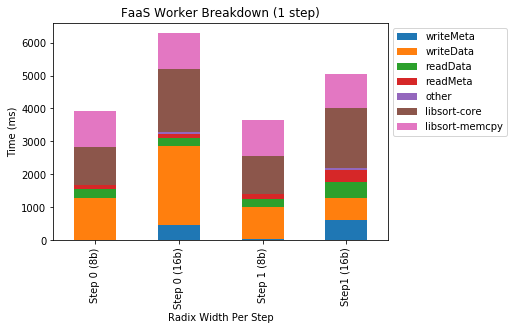

In [67]:
pltDf = pd.DataFrame([means['8b']['First'], means['16b']['First'], means['8b']['Middle'], means['16b']['Middle']], index=["Step 0 (8b)", "Step 0 (16b)", "Step 1 (8b)", "Step1 (16b)"])
ax = pltDf.plot.bar(stacked=True)

ax.set_xlabel("Radix Width Per Step")
ax.set_ylabel("Time (ms)")
ax.set_title("FaaS Worker Breakdown (1 step)")
ax.legend(bbox_to_anchor=(1.0, 1.0))
# ax.get_figure().savefig("faasTimeBreakdown.png", dpi=300, bbox_inches = "tight")

There are some clear trends to note. Read metadata handling more than doubles in the 16b case for intermediate steps since it must now perform the complex gather from many partitions. The initial step reads a simple contiguous chunk of data from a single partition. Write metadata handling is even more striking. It goes from trivial to a large portion of the runtime as we increase the bitwidth. It is dominated by JSON serialization. This could be reduced by switching to a more efficient binary format.

### Variance and Unexplained Behavior

There are a number of things about these results that don't make immediate sense. Firstly, writing data takes significantly longer than reading despite processing the same amount of data (about 2GB). Additionally, writing takes longer on step 0 verses intermediate steps. Writing time should be consistent. Next we notice that metadata processing takes significantly longer when writing vs reading. Unlike data, metadata is dominated by JSON processing, the actual data volume is only a few megabytes. In theory, reading should be slower as it must decode two arrays worth of metadata. It is not clear why this is.

Closer investigation reveals that not only are the average times skewed, the variance is very high for writing, especially in the first step. It is possible that this is due to details of the Linux filesystem, ideally this experiment would go through a memory-backed filesystem (or a different backing store) to minimize this discrepancy.

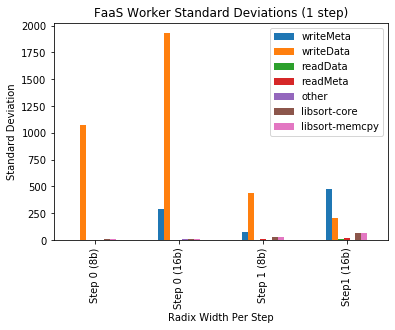

In [70]:
pltDf = pd.DataFrame([stds['8b']['First'], stds['16b']['First'], stds['8b']['Middle'], stds['16b']['Middle']], index=["Step 0 (8b)", "Step 0 (16b)", "Step 1 (8b)", "Step1 (16b)"])
ax = pltDf.plot.bar()

ax.set_xlabel("Radix Width Per Step")
ax.set_ylabel("Standard Deviation")
ax.set_title("FaaS Worker Standard Deviations (1 step)")
ax.legend(bbox_to_anchor=(1.0, 1.0))
# ax.get_figure().savefig("faasStds.png", dpi=300, bbox_inches = "tight")

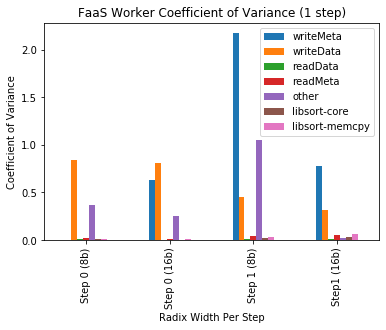

In [64]:
pltDf = pd.DataFrame([covs['8b']['First'], covs['16b']['First'], covs['8b']['Middle'], covs['16b']['Middle']], index=["Step 0 (8b)", "Step 0 (16b)", "Step 1 (8b)", "Step1 (16b)"])
ax = pltDf.plot.bar()

ax.set_xlabel("Radix Width Per Step")
ax.set_ylabel("Coefficient of Variance")
ax.set_title("FaaS Worker Coefficient of Variance (1 step)")
ax.legend(bbox_to_anchor=(1.0, 1.0))
# ax.get_figure().savefig("faasBreakdown.png", dpi=300, bbox_inches = "tight")